In [10]:
%matplotlib inline
%mcmc notebook
import matplotlib.pyplot as plt
from autograd import numpy as np
import numpy as true_np
import sympy as sp
import bayesian_pdes
import mcmc
sp.init_printing()

ERROR: Line magic function `%mcmc` not found.


In [2]:
# TODO: generate and load some real data here.

Model:

$$
-\nabla \cdot \exp\left(\sum_{i=1}^4 \theta_i \sin(i \cdot 2\pi x) \right) \nabla u = 0 \\
u = 0
$$

In [196]:
S = 4
x, y = sp.symbols('x y')
thetas = list(sp.symbols(' '.join(['theta_{}'.format(i) for i in xrange(S)])))
def get_c(x_1):
    c = sp.exp(sum([theta*sp.cos(2*i*sp.pi*x) for i,theta in enumerate(thetas)]))
    return c

In [197]:
length_scale = 0.1
k_sqexp = sp.exp(-((x-y)**2 / (2*length_scale**2)))
A = lambda k: (get_c(x)*k.diff(x)).diff(x)
Abar = lambda k: (get_c(y)*k.diff(y)).diff(y)
Identity = lambda k: k
B_1 = B_1_bar = Identity

In [198]:
ops = [A, B_1, B_2]
ops_bar = [Abar, B_1_bar, B_2_bar]
op_cache = bayesian_pdes.operator_compilation.compile_sympy(ops, ops_bar, k_sqexp, [[x], [y], thetas])

In [209]:
all = np.linspace(0,1,11)[:,None]
boundary_flags = ((all[:,0] == 0) | (all[:,0] == 1))
interior_flags = ~boundary_flags
boundary = all[boundary_flags, :]
interior = all[interior_flags, :]

In [210]:
interior_obs = np.sin(2*np.pi*interior)
boundary_obs = np.array([[1.], [-1.]])
obs = [
    (interior, interior_obs),
    (boundary, boundary_obs),
]

In [211]:
true_theta = np.ones(S)

posterior = bayesian_pdes.collocate(ops, ops_bar, None, None, obs, op_cache, fun_args=[true_theta])

In [212]:
test_x = np.linspace(0, 1)[:,None]
mu, Sigma = posterior(test_x)
mu_shaped = mu.reshape(test_x.shape)

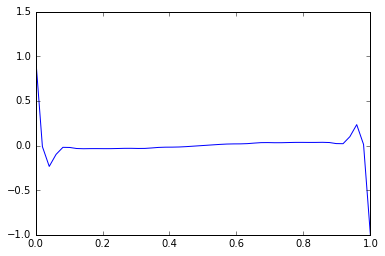

In [213]:
plt.plot(test_x, mu_shaped)

In [184]:
init_theta = np.ones(S)

In [131]:
from scipy import stats
def propose(current):
    return np.random.normal(current, proposal_sigma)
def proposal_proba(proposal, current):
    return stats.multivariate_normal.logpdf(proposal, current, proposal_sigma)
def log_likelihood(theta):
    posterior = bpdes.collocate(ops, ops_bar, None, None, obs, op_cache, [theta])
    mu,cov = posterior(true_x)
    cov_with_error = cov + likelihood_sigma*np.eye(cov.shape[0])
    ret = stats.multivariate_normal.logpdf(true_u, mu.ravel(), cov_with_error, False)
    return ret
    err = (true_u - mu.ravel()).reshape((mu.shape[0], 1))
    cov_inv = np.linalg.inv(cov_with_error)
    inner = -0.5*err.T.dot(cov_inv).dot(err)
    outer = -0.5*np.log(np.linalg.det(2*np.pi*cov_with_error))
    return (inner + outer)[0,0]
def log_prior_lognormal(theta):
    if np.any(theta <= 0): return np.log(0)
    p = stats.norm.logpdf(np.log(theta), np.ones_like(theta), 1.) - np.log(theta)
    return np.sum(p)
def log_prior_normal(theta):
    p = stats.norm.logpdf(theta, np.zeros_like(theta), 1.)
    return np.sum(p)
def log_prior_uniform(theta):
    theta_min = -20.
    theta_max = 20.
    if any((theta < theta_min) | (theta > theta_max)):
        return np.log(0)
    return len(theta)*np.log(1./(theta_max-theta_min))

In [37]:
log_prior = log_prior_normal

In [67]:

cur_theta = init_theta
# now the MCMC
iterations = 5000
thetas = np.empty((iterations, cur_theta.shape[0]))
proposals = np.empty((iterations, cur_theta.shape[0]))
thetas[0,:] = init_theta
proposal_sigma = 0.5
likelihood_sigma = 0.0005

last_likelihood = log_likelihood(thetas[0,:])
last_prior = log_prior(thetas[0,:])
acceptances = np.empty(iterations, dtype=np.bool)
acceptances[0] = True
alphas = np.empty(iterations)

cur_theta = init_theta
update_frequency = int(iterations / 100)
for i in xrange(iterations):
    if i % int(iterations / 100) == 0:
        
        print i, acceptances[i-iterations/100:i].sum() * 1./(iterations * 1./100)
    next_theta = propose(cur_theta)
    proposals[i,:] = next_theta
    
    new_likelihood = log_likelihood(next_theta)
    new_prior = log_prior(next_theta)
    
    alpha = np.exp(new_likelihood + new_prior)*np.exp(-(last_likelihood + last_prior))
    if np.isnan(alpha): 
        raise Exception()
    else:
        accept = np.random.uniform() < alpha
    alphas[i] = alpha
    acceptances[i] = accept
    if accept == True:
        #print 'Accepted'
        cur_theta = next_theta
        last_likelihood = new_likelihood
        last_prior = new_prior
    
    thetas[i,:] = cur_theta


0 0.0
50 0.52
100 0.62
150 0.32
200 0.46
250 0.48
300 0.54
350 0.52
400 0.48
450 0.6
500 0.56
550 0.56
600 0.44
650 0.6
700 0.54
750 0.52
800 0.52
850 0.68
900 0.56
950 0.58
1000 0.64
1050 0.54
1100 0.52
1150 0.44
1200 0.5
1250 0.48
1300 0.58
1350 0.54
1400 0.56
1450 0.7
1500 0.44
1550 0.52
1600 0.54
1650 0.56
1700 0.52
1750 0.52
1800 0.48
1850 0.42
1900 0.5
1950 0.42
2000 0.58
2050 0.5
2100 0.46
2150 0.62
2200 0.44
2250 0.54
2300 0.54
2350 0.52
2400 0.48
2450 0.52
2500 0.52
2550 0.6
2600 0.62
2650 0.5
2700 0.56
2750 0.58
2800 0.34
2850 0.46
2900 0.58
2950 0.52
3000 0.58
3050 0.52
3100 0.6
3150 0.46
3200 0.58
3250 0.5
3300 0.56
3350 0.48
3400 0.54
3450 0.46
3500 0.56
3550 0.48
3600 0.64
3650 0.6
3700 0.44
3750 0.38
3800 0.54
3850 0.54
3900 0.5
3950 0.6
4000 0.54
4050 0.66
4100 0.46
4150 0.38
4200 0.52
4250 0.52
4300 0.54
4350 0.58
4400 0.56
4450 0.58
4500 0.62
4550 0.58
4600 0.54
4650 0.54
4700 0.64
4750 0.56
4800 0.52
4850 0.52
4900 0.58
4950 0.58


In [39]:
#thetas = np.load('pn_n=11_ls=0.2.npy')
#thetas[:,1] = -thetas[:,1]
#thetas[:,3] = -thetas[:,3]

In [40]:
#thetas = np.load('pn_n=11.npy')

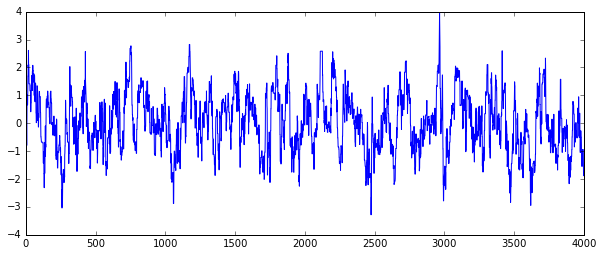

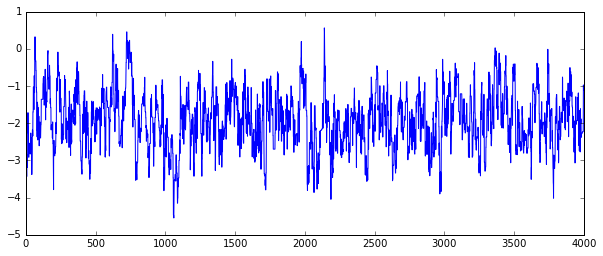

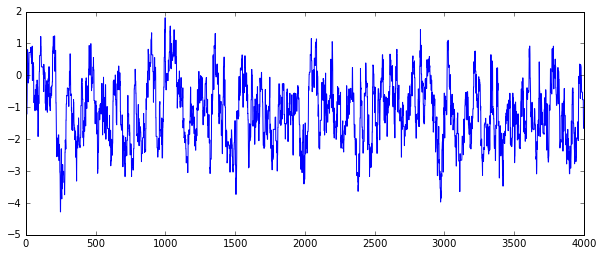

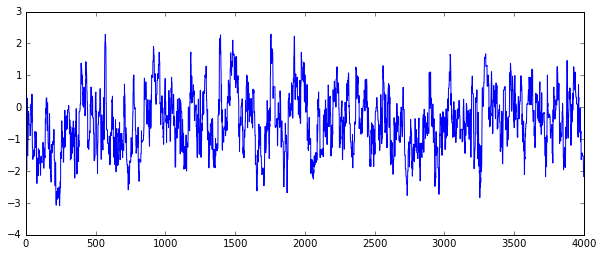

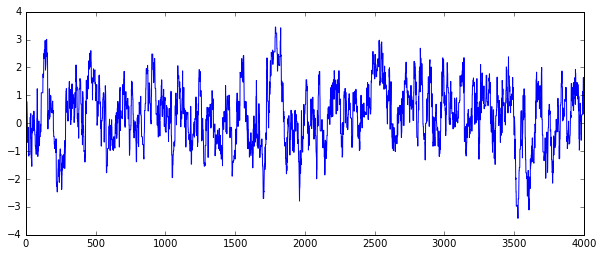

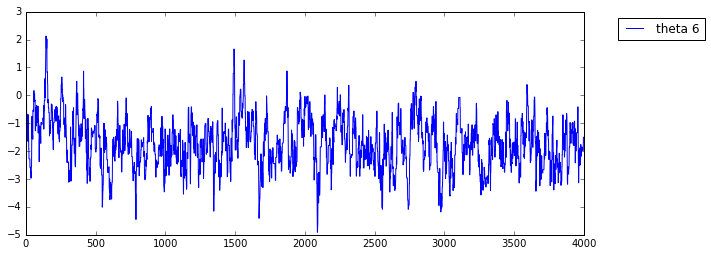

In [68]:
plt.figure(figsize=(8,5))
#print acceptances.sum() * 1./iterations
thin= 1
burn = 1000
thinned_burned = thetas[burn:-1:thin, :]
for i in xrange(6):
    plt.figure(figsize=(10,4))
    plt.plot(thinned_burned[:,i], label='theta {}'.format(i+1))
plt.legend(loc=2, bbox_to_anchor=(1.05,1))

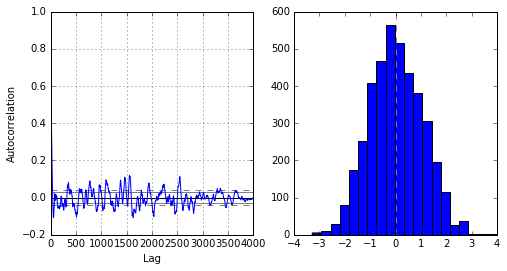

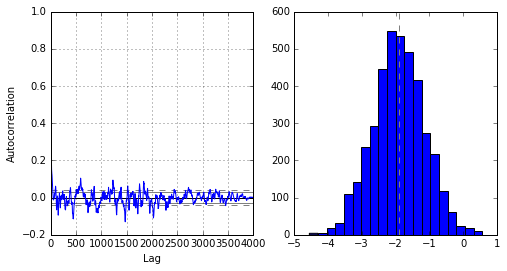

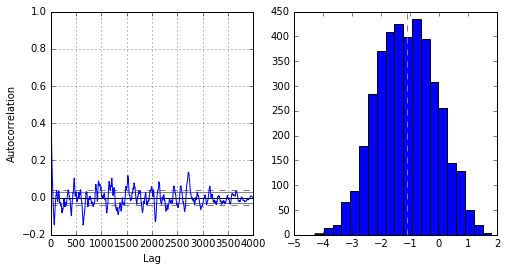

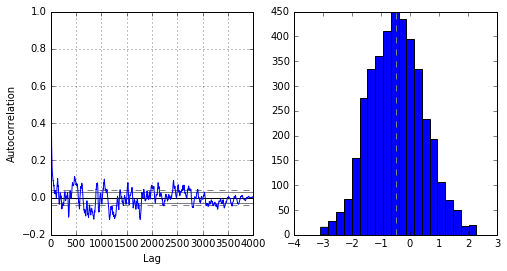

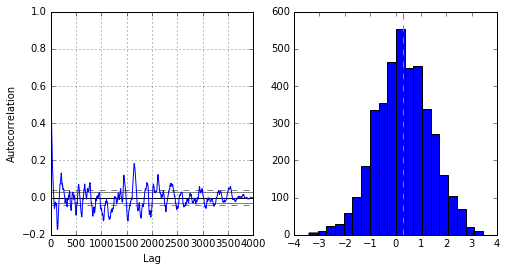

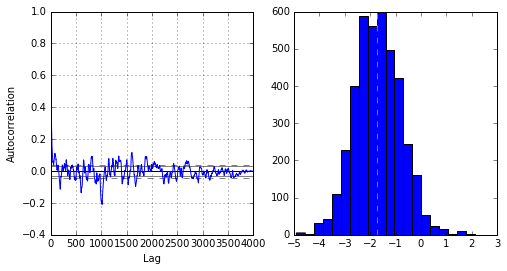

In [69]:
from pandas.tools.plotting import autocorrelation_plot
for i in xrange(thinned_burned.shape[1]):
    t = thinned_burned[:,i]
    plt.figure(figsize=(8,4))
    plt.subplot(121)
    autocorrelation_plot(t, ax=plt.gca())
    plt.subplot(122)
    plt.hist(t, bins=20)
    plt.axvline(t.mean(), linestyle='--', c='gray')

In [70]:
import math
def integers_between(min, max):
    min_int = int(math.floor(min))
    max_int = int(math.ceil(max))
    print min_int, max_int
    return range(min_int, max_int+1)

-5 3
-4 4
-5 1
-5 2
-4 3
-4 4


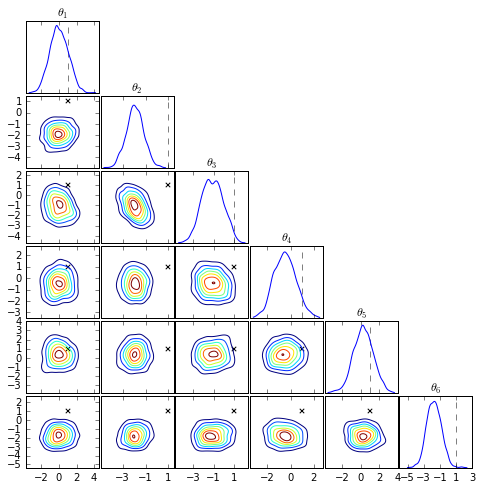

In [71]:
from matplotlib import gridspec
from scipy import stats
plt.figure(figsize=(8,8))
diag = []
n = 6
gs = gridspec.GridSpec(n, n)
gs.update(wspace=0.025, hspace=0.05)

#levels = [5,20,40,60]

levels = None
for i in range(n):
    i_data = thinned_burned[:,i]
    ax = plt.subplot(gs[n*i + i])
    kde = stats.gaussian_kde(i_data)
    eval_points = np.linspace(i_data.min()-0.1, i_data.max()+0.2, 100)
    #plt.axvline(i_data.mean(), linestyle='--', color='gray')
    plt.axvline(1, linestyle='--', color='gray')
    #plt.axvline(-1, linestyle='--', color='gray')
    plt.plot(eval_points, kde(eval_points))
    plt.title('$\\theta_{}$'.format(i+1))
    
    
    ax.get_yaxis().set_ticks([])
    if i < n-1:
        plt.setp(ax.get_xticklabels(), visible=False)
    else:
        plt.xticks(integers_between(i_data.min(), i_data.max())[::2])
    for j in range(0,i):
        j_data = thinned_burned[:,j]
        subax = plt.subplot(gs[n*i+j], sharex=diag[j])
        #H,xedges,yedges = np.histogram2d(j_data, i_data, bins=20)
        kde = stats.gaussian_kde(np.c_[j_data, i_data].T, bw_method=0.35)
        x,y = np.mgrid[j_data.min()-0.1:j_data.max()+0.1:100j, i_data.min()-0.1:i_data.max()+0.2:100j]
        plt.contour(x, y, kde(np.c_[x.ravel(), y.ravel()].T).reshape(x.shape))
        #plt.contour(xedges[:-1], yedges[:-1], H, levels=levels)
        if j > 0:
            subax.get_yaxis().set_ticks([])
        if i < n-1:
            plt.setp(subax.get_xticklabels(), visible=False)
        else:
            plt.xticks(integers_between(j_data.min(), j_data.max())[::2])
        #plt.scatter([1,1,-1,-1],[1,-1,1,-1], marker='x', color='black', linewidth=2, zorder=10)
        plt.scatter(1,1,marker='x', color='black')
    diag.append(ax)
    
plt.gcf().patch.set_alpha(0)
#plt.savefig('PN.pdf', bbox_inches='tight')
plt.savefig('PN_{}.pdf'.format(seed), bbox_inches='tight')
np.save('thetas_{}.npy'.format(seed), thetas)

In [304]:
kde(np.c_[x.ravel(), y.ravel()].T).reshape(x.shape)

ValueError: points have dimension 2, dataset has dimension 1

In [302]:
np.c_[x.ravel(), y.ravel()]

array([[ 0.        ,  0.        ],
       [ 0.        ,  0.02564103],
       [ 0.        ,  0.05128205],
       ..., 
       [ 1.        ,  0.94871795],
       [ 1.        ,  0.97435897],
       [ 1.        ,  1.        ]])

In [283]:
print H.shape, xedges.shape

(40,) (21,)


In [136]:
(H > 2).sum()

In [139]:
(H > 10).sum()

In [145]:
(H > 80).sum()

In [425]:
np.save('pn_n=11.npy', thetas)

In [ ]:
np.exp(-last_likelihood - last_prior)

In [ ]:
np.exp(new_likelihood + new_prior)

In [ ]:
posterior = bpdes.collocate(ops, ops_bar, k, None, obs, op_cache, [cur_theta])
mu,cov = posterior(true_x)

In [ ]:
np.dot(mu.ravel()-true_u, np.linalg.inv(cov+likelihood_sigma**2*np.eye(cov.shape[0]))).dot(mu.ravel()-true_u)

In [ ]:
np.exp(0.5*np.log(np.linalg.det(cov+likelihood_sigma**2*np.eye(cov.shape[0]))) + np.dot(mu.ravel()-true_u, np.linalg.inv(cov+likelihood_sigma**2*np.eye(cov.shape[0]))).dot(mu.ravel()-true_u))